# 1. Install Requirements

In [ ]:
!pip install -U sentence-transformers

# 2. Load LaBSE

In [ ]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/LaBSE')
embeddings = model.encode(sentences)
print(embeddings)

[[ 0.02882475 -0.00602381 -0.05947007 ... -0.03002252 -0.029607
   0.00067483]
 [-0.05550233  0.02546483 -0.02157258 ...  0.02932105  0.01150041
  -0.00848787]]


# 3. Load & Preprocess Data

To run cell below you should put all data files on the same folder as this notebook.

In [ ]:
import pandas as pd
import json

with open("train.model-agnostic.json", "r") as f:
    train_agnostic = pd.DataFrame(json.loads(f.read()))
with open("train.model-aware.json", "r") as f:
    train_aware = pd.DataFrame(json.loads(f.read()))
with open("val.model-agnostic.json", "r") as f:
    val_agnostic = pd.DataFrame(json.loads(f.read()))
with open("val.model-aware.json", "r") as f:
    val_aware = pd.DataFrame(json.loads(f.read()))
with open("trial-v1.json", "r") as f:
    test = pd.DataFrame(json.loads(f.read()))

In [ ]:
def split_hyp_tgt(data_df):
    hyps = []
    tgts = []
    for index, row in data_df.iterrows():
        hyps.append(row['hyp'])
        if row['ref'] == 'either' or row['ref'] == 'tgt':
            tgts.append(row['tgt'])
        else:
            tgts.append(row['src'])

    return hyps, tgts

In [ ]:
h_train_agnostic, t_train_agnostic = split_hyp_tgt(train_agnostic)
h_train_aware, t_train_aware = split_hyp_tgt(train_aware)
h_val_agnostic, t_val_agnostic = split_hyp_tgt(val_agnostic)
h_val_aware, t_val_aware = split_hyp_tgt(val_aware)
h_test, t_test = split_hyp_tgt(test)

## Labels for Val and Test Data

In [ ]:
label_val_agnostic = np.array(val_agnostic['p(Hallucination)'])
label_val_aware = np.array(val_aware['p(Hallucination)'])
label_test = np.array(test['p(Hallucination)'])

# 4. Get Embeddings & Calculate Similarity Scores

In [ ]:
h_val_agnostic, t_val_agnostic = model.encode(h_val_agnostic), model.encode(t_val_agnostic)
h_val_aware, t_val_aware = model.encode(h_val_aware), model.encode(t_val_aware)
h_test, t_test = model.encode(h_test), model.encode(t_test)

In [ ]:
t_test.shape

(80, 768)

In [ ]:
import numpy as np

def similarity(embeddings_1, embeddings_2):
    return np.sum(np.multiply(embeddings_1, embeddings_2), 1)

In [ ]:
val_agnostic_scores = 1 - similarity(h_val_agnostic, t_val_agnostic)
val_aware_scores = 1 - similarity(h_val_aware, t_val_aware)
test_scores = 1 - similarity(h_test, t_test)

# 5. Evaluation

In [ ]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import scipy.stats


def AUC_metric(scores, labels):
    y = np.where(labels >= 0.5, 1, 0)
    pred = scores
    fpr, tpr, thresholds = metrics.roc_curve(y, pred)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                    estimator_name='example estimator')
    display.plot()
    plt.show()

def accuracy(scores, labels, threshold=0.5):
    y = np.where(labels >= 0.5, 1, 0)
    pred = np.where(scores >= threshold, 1, 0)

    return metrics.accuracy_score(y, pred)

def S_correlation(scores, labels):
    spearman_corr, p_value = scipy.stats.spearmanr(scores, labels)
    return spearman_corr

def evaluate(name, scores, labels):
    print(name, "accuracy:", accuracy(scores, labels))
    print(name, "spearman correlation:", S_correlation(scores, labels))
    AUC_metric(scores, labels)

Val Agnostic accuracy: 0.657314629258517
Val Agnostic spearman correlation: 0.47621837330082306


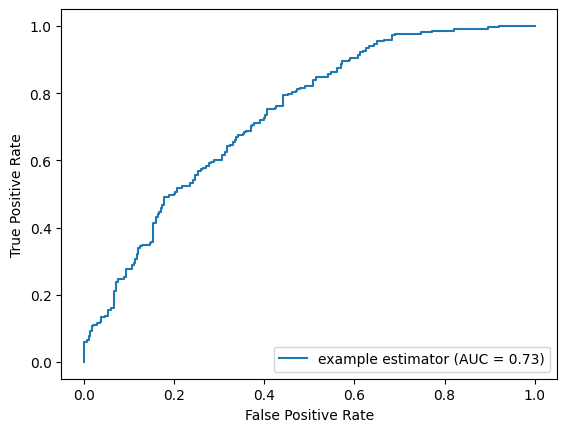

In [ ]:
evaluate("Val Agnostic", val_agnostic_scores, label_val_agnostic)

Val Aware accuracy: 0.6646706586826348
Val Aware spearman correlation: 0.3946109573624804


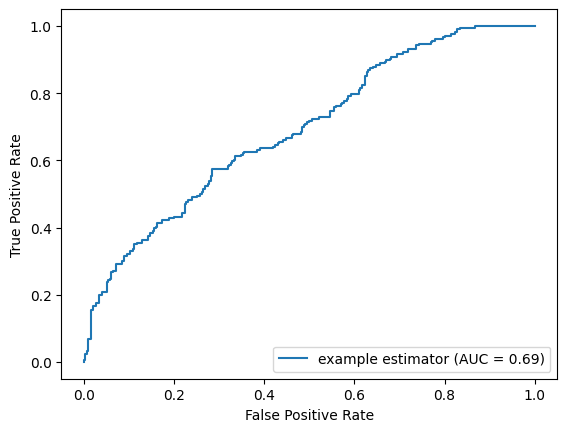

In [ ]:
evaluate("Val Aware", val_aware_scores, label_val_aware)

Test accuracy: 0.6125
Test spearman correlation: 0.469378050127969


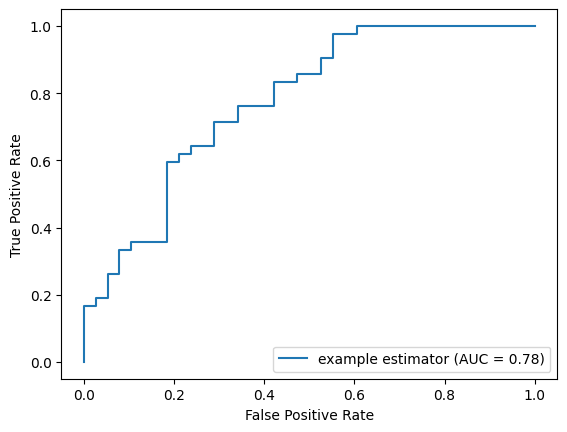

In [ ]:
evaluate("Test", test_scores, label_test)

In [ ]:
# All test and val data together
all_scores = np.concatenate([val_agnostic_scores, val_aware_scores, test_scores])
all_labels = np.concatenate([label_val_agnostic, label_val_aware, label_test])

All Test & Val Data accuracy: 0.6574074074074074
All Test & Val Data spearman correlation: 0.4458345164188204


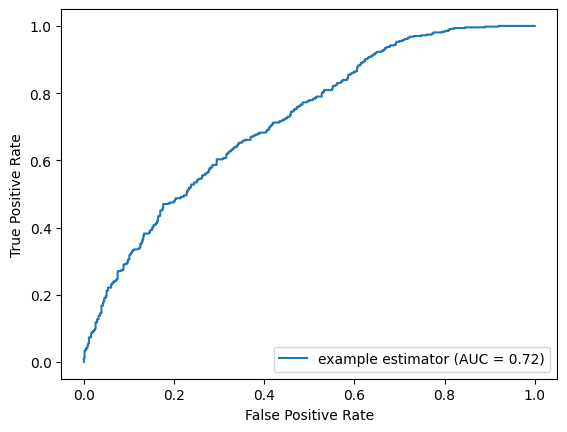

In [ ]:
evaluate("All Test & Val Data", all_scores, all_labels)

# 6. Results

Data         | AUC | Accuracy | Spearman Correlation |
----------   | --- | -------- | ---------------------|
Val Agnostic |0.73 | 0.65     | 0.47                 |
Val Aware    |0.69 | 0.66     | 0.39                 |
Test         |0.78 | 0.61     | 0.46                 |
All          |0.72 | 0.65     | 0.44                 |